# Node Classification on large Knowledge Graphs

In [1]:
"""https://colab.research.google.com/drive/1LJir3T6M6Omc2Vn2GV2cDW_GV2YfI53_?usp=sharing#scrollTo=-3dnSaQnR6Ci"""

"""https://youtu.be/ex2qllcVneY"""

'https://youtu.be/ex2qllcVneY'

In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root="data/Planetoid", name="Cora", transform=NormalizeFeatures())


Processing...
Done!
Processing...
Done!


# Basic info about dataset and data

In [14]:
#Get some basic information about the dataset
print(f"number of graphs:{len(dataset)}")
print(f"number of features:{dataset.num_features}")
print(f"number of classes:{dataset.num_classes}")
print(60 * "*")
#There is only 1 graph in the dataset , which will be used as the new data
data = dataset[0]
#Gather some statistics about the graph
print(data)
"""
x : feature matrix of all nodes
edge_index: a matrix : columns -> edges , rows-> the nodes each edge links
y : labels
masks:The masks are implemented as boolean tensors, where each element represents whether the corresponding node in the graph belongs to the training or validation or test set.
"""
print(data.train_mask)
print(data.val_mask)
print(data.test_mask)
print(f"number of nodes:{data.num_nodes}")
print(f"number of edges:{data.num_edges}")
print(f"number of  training nodes:{data.train_mask.sum()}")
# print(type(data.train_mask.sum()))
print(f"Training node label rate:{int(data.train_mask.sum()) / data.num_nodes : .3f}")
print(f"Is Undirected:{data.is_undirected()}")

number of graphs:1
number of features:1433
number of classes:7
************************************************************
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
tensor([ True,  True,  True,  ..., False, False, False])
tensor([False, False, False,  ..., False, False, False])
tensor([False, False, False,  ...,  True,  True,  True])
number of nodes:2708
number of edges:10556
number of  training nodes:140
<class 'torch.Tensor'>
Training node label rate: 0.052
Is Undirected:True


# Feature Matrix

In [19]:
print(data.x.shape)
# Print e.g : the first 50 features of the first node
# these features are normalized
print(data.x[0][0:50])

torch.Size([2708, 1433])
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


# Label matrix

In [22]:
# we have 7 labels -> as numeric values 0:6
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

# Example for the binary mask

In [27]:
print(len(data.train_mask)==data.num_nodes)
data.train_mask

True


tensor([ True,  True,  True,  ..., False, False, False])

# Example for edge connections

In [32]:
print(len(data.edge_index))
print(len(data.edge_index.t()))
data.edge_index.t() # t() for transpose

2
10556


tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

# GNN for Node Classification

In [33]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv #GATConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # Initialize the layers
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training) #Dropout is only applied in the training step, but not for predictions

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Output layer
        x = F.softmax(self.out(x), dim=1)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)


# Training and Evaluation

In [34]:
# Initialize model
model = GCN(hidden_channels=16)

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

# Initialize Optimizer
learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=decay)
# Define loss function (CrossEntropyLoss for Classification Problems with
# probability distributions)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      # Use all data as input, because all nodes have node features
      out = model(data.x, data.edge_index)
      # Only use nodes with labels available for loss calculation --> mask
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      # Use the class with highest probability.
      pred = out.argmax(dim=1)
      # Check against ground-truth labels.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      # Derive ratio of correct predictions.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc

losses = []
for epoch in range(0, 1001):
    loss = train()
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 1.9461
Epoch: 100, Loss: 1.8616
Epoch: 200, Loss: 1.7218
Epoch: 300, Loss: 1.6939
Epoch: 400, Loss: 1.6404
Epoch: 500, Loss: 1.5425
Epoch: 600, Loss: 1.4896
Epoch: 700, Loss: 1.4563
Epoch: 800, Loss: 1.3822
Epoch: 900, Loss: 1.3775
Epoch: 1000, Loss: 1.3338


# Visualize the training loss

<Axes: >

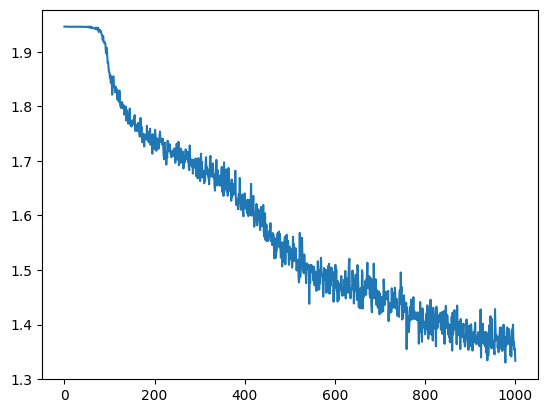

In [37]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i,l in enumerate(losses_float)]
plt = sns.lineplot( losses_float)
plt

# Calculate test metric

In [38]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7480


# Visualizing the embeddings

torch.Size([2708, 7])


<Axes: >

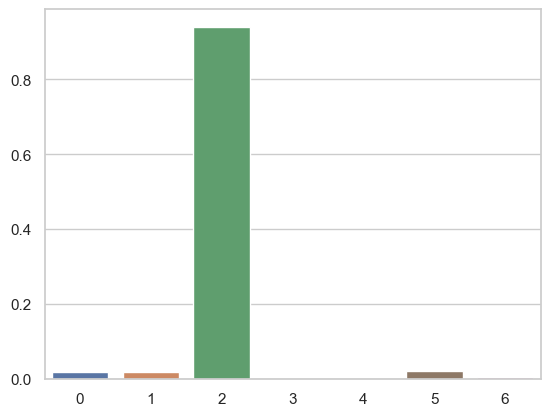

In [39]:
import seaborn as sns
import numpy as np
sample = 9
sns.set_theme(style="whitegrid")
print(model(data.x, data.edge_index).shape)
pred = model(data.x, data.edge_index)
sns.barplot(x=np.array(range(7)), y=pred[sample].detach().cpu().numpy())

In [40]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def plt2arr(fig):
    rgb_str = fig.canvas.tostring_rgb()
    (w,h) = fig.canvas.get_width_height()
    rgba_arr = np.fromstring(rgb_str, dtype=np.uint8, sep='').reshape((w,h,-1))
    return rgba_arr


def visualize(h, color, epoch):
    fig = plt.figure(figsize=(5,5), frameon=False)
    fig.suptitle(f'Epoch = {epoch}')
    # Fit TSNE with 2 components
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    # Create scatterplot from embeddings
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0],
                z[:, 1],
                s=70,
                c=color.detach().cpu().numpy(),
                cmap="Set2")
    fig.canvas.draw()

    # Convert to numpy
    return plt2arr(fig)


# Reset the previously trained model weights
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

TSNE Visualization finished.


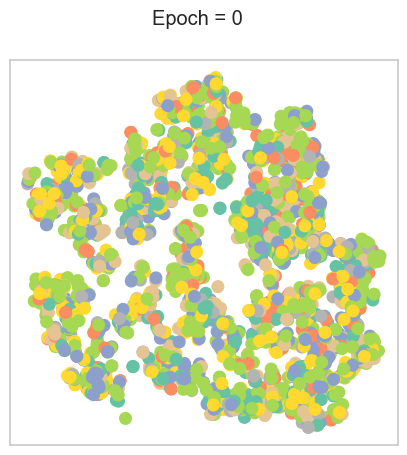

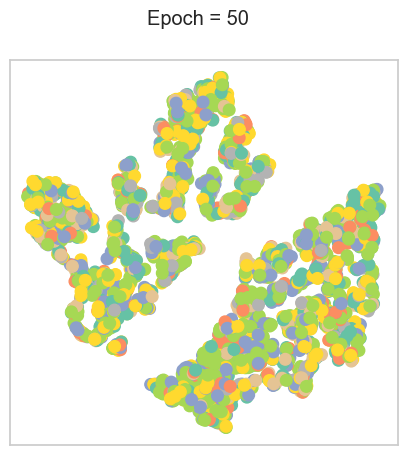

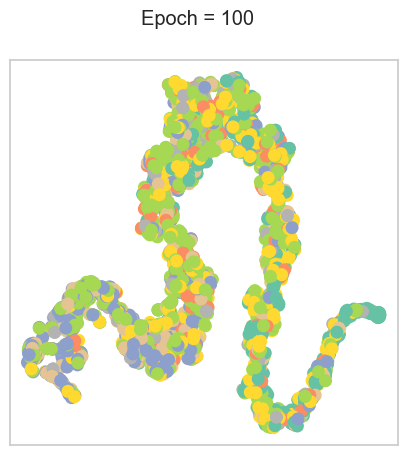

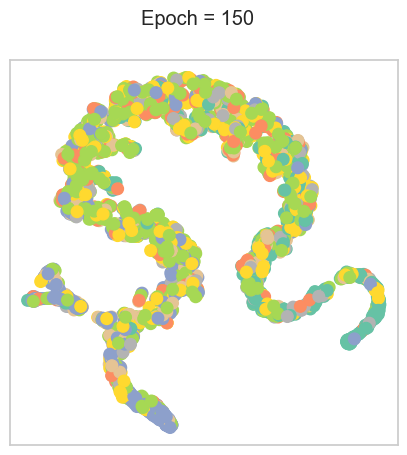

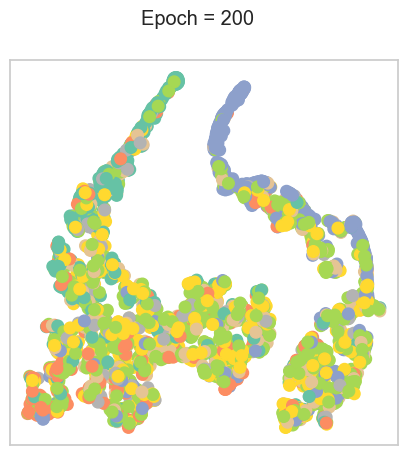

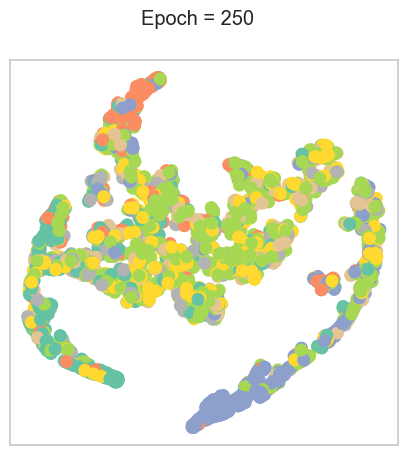

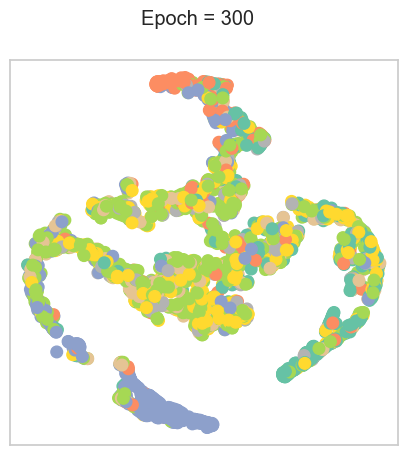

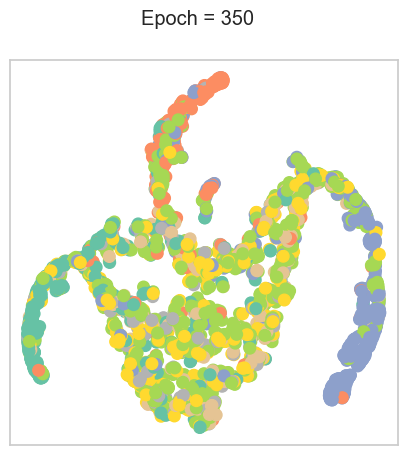

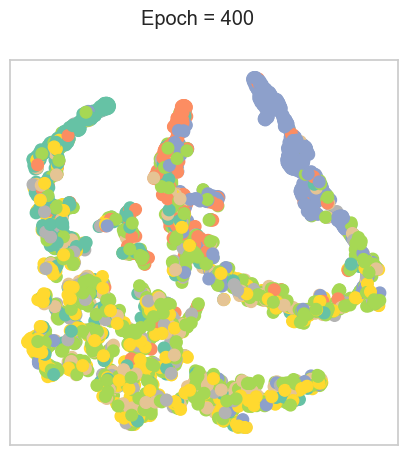

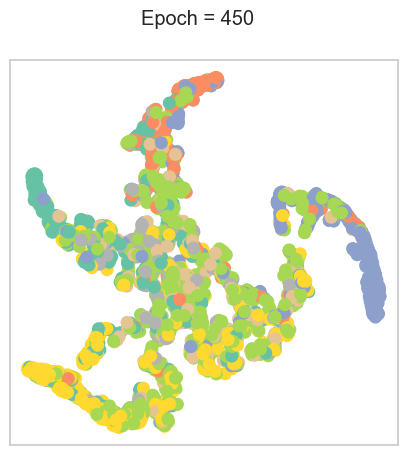

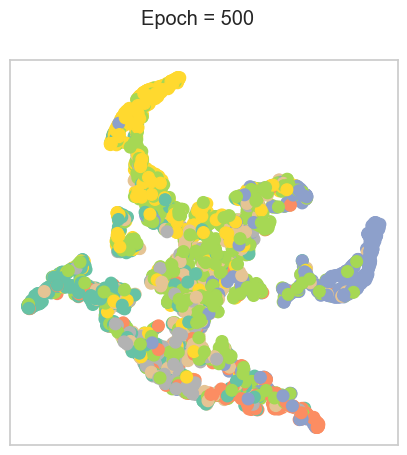

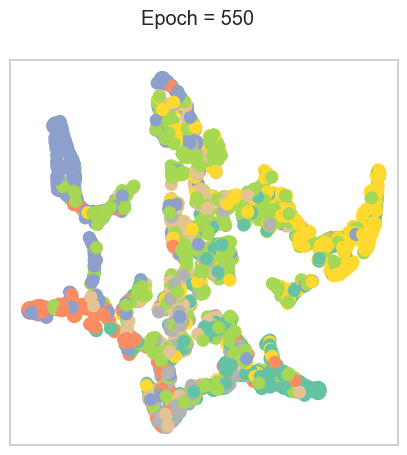

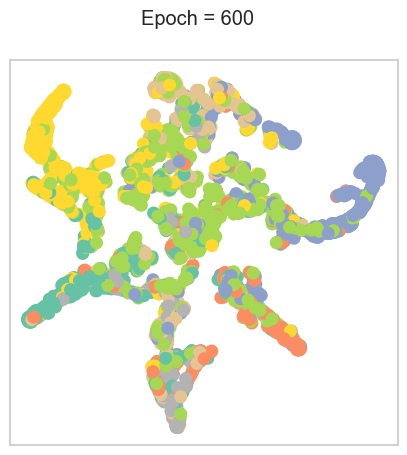

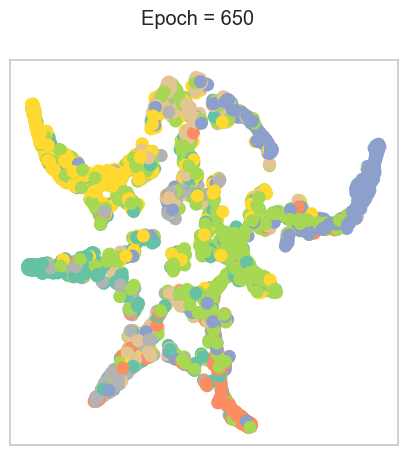

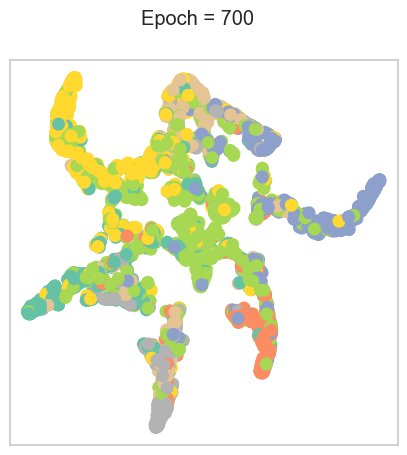

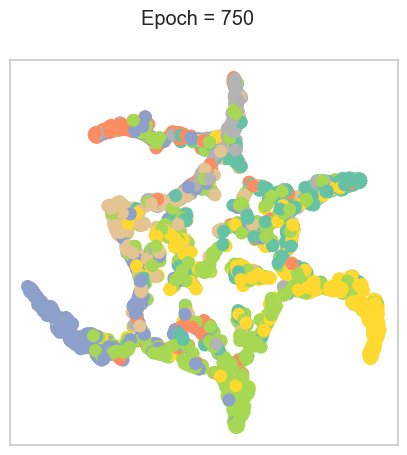

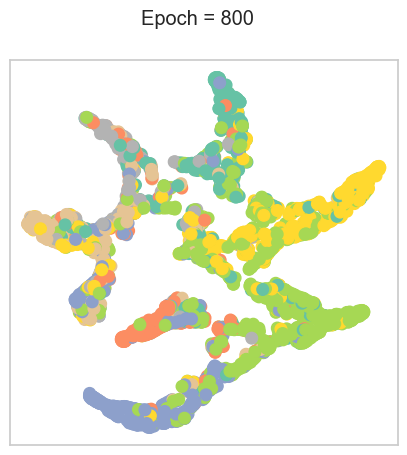

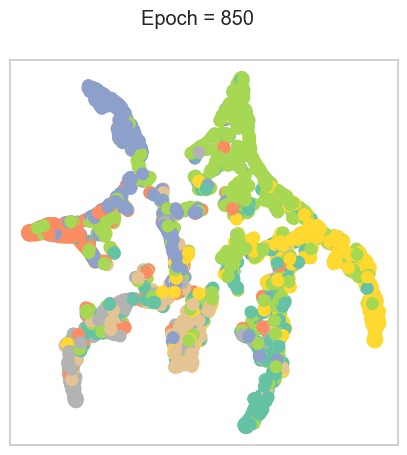

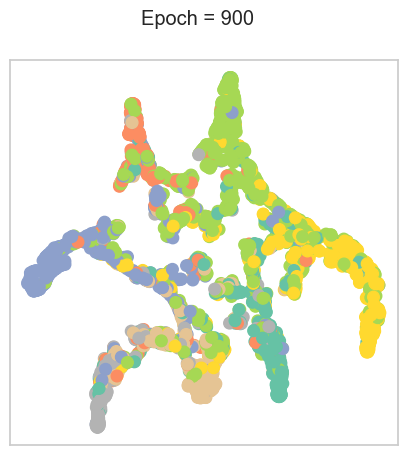

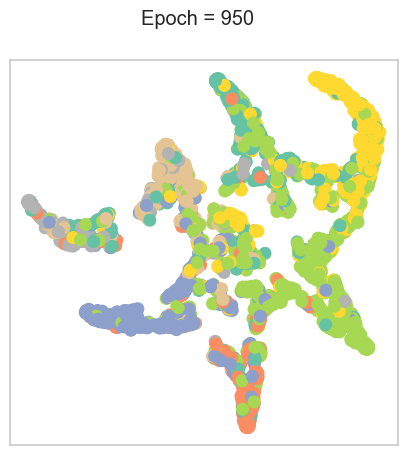

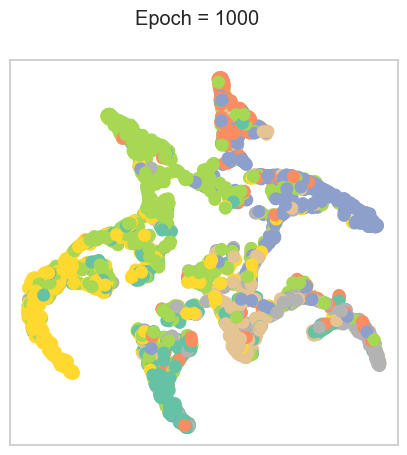

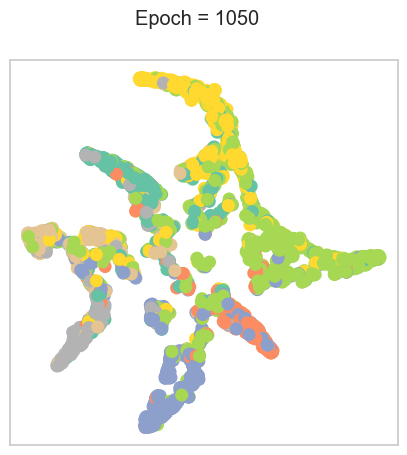

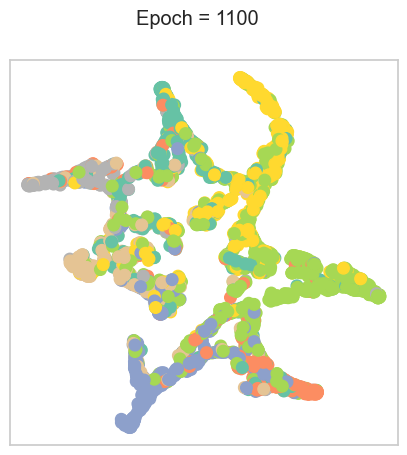

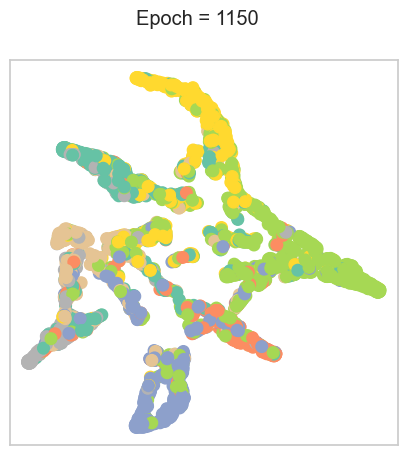

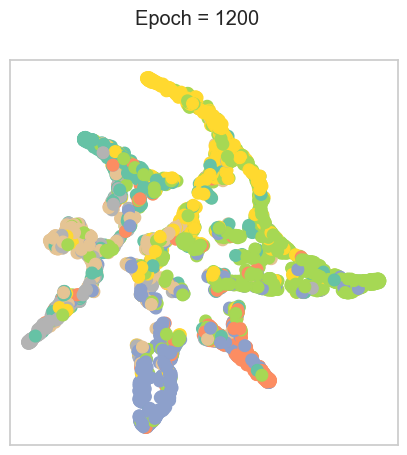

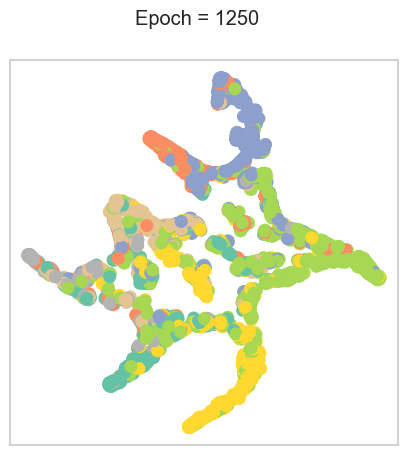

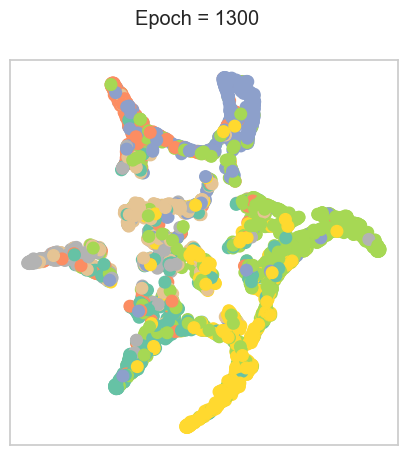

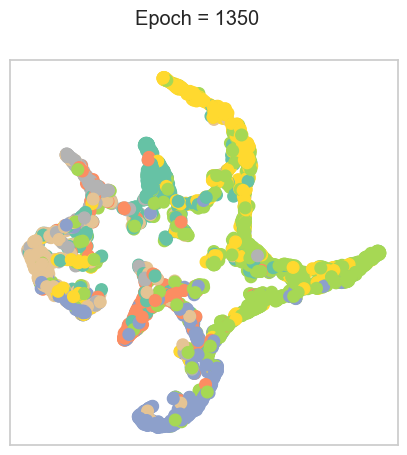

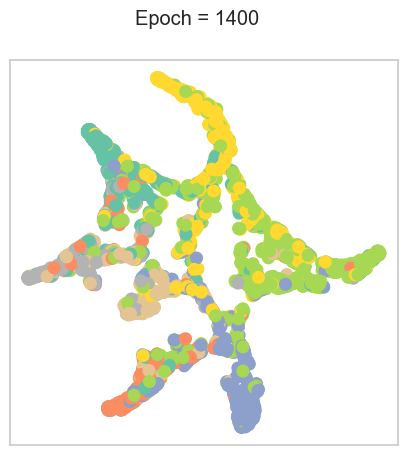

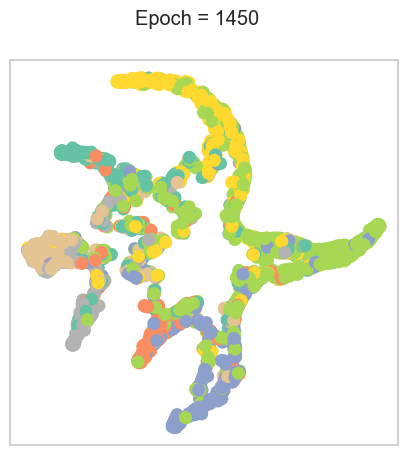

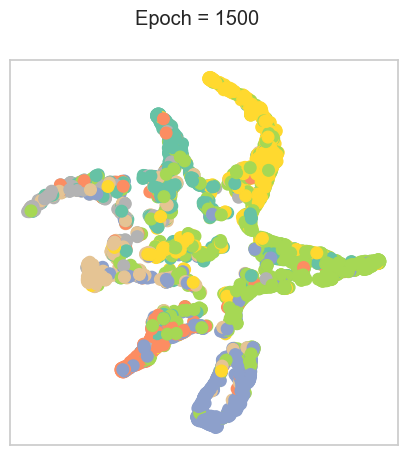

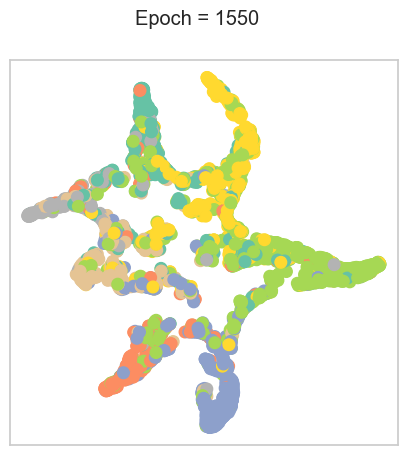

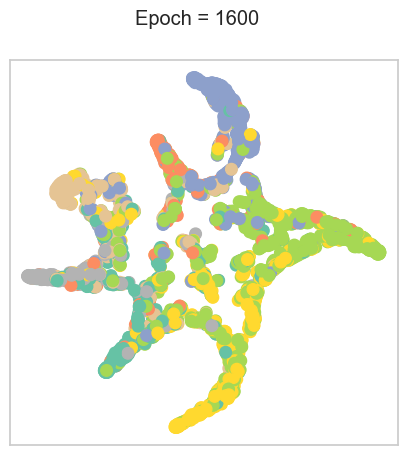

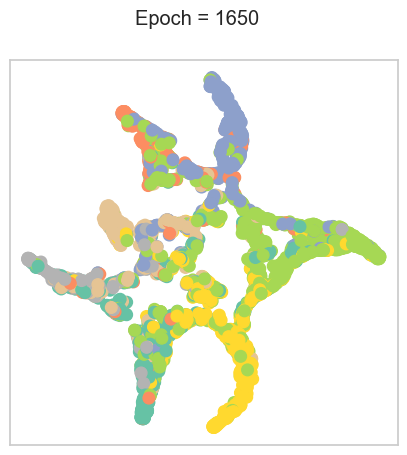

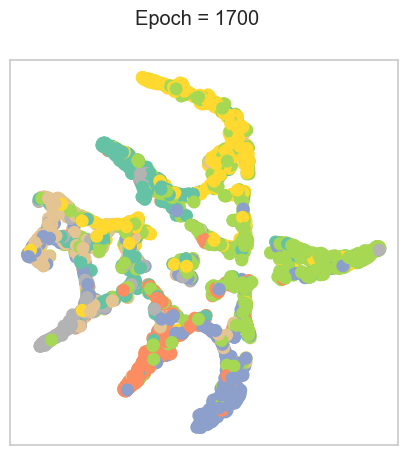

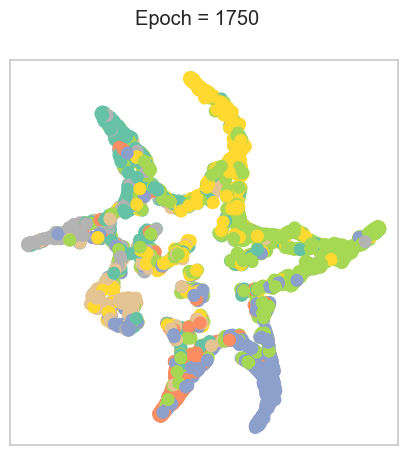

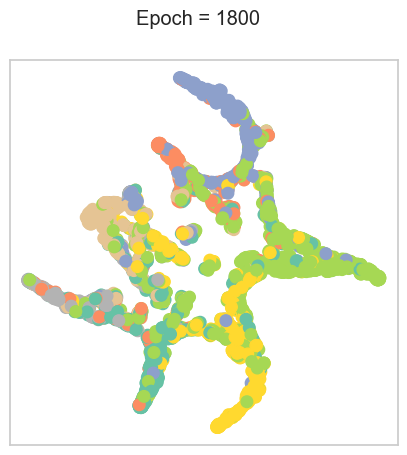

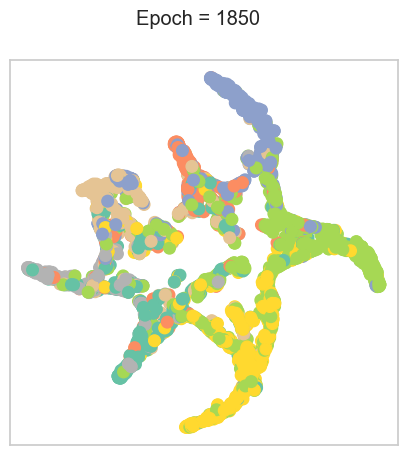

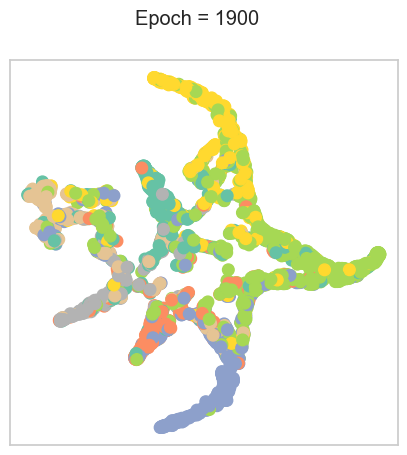

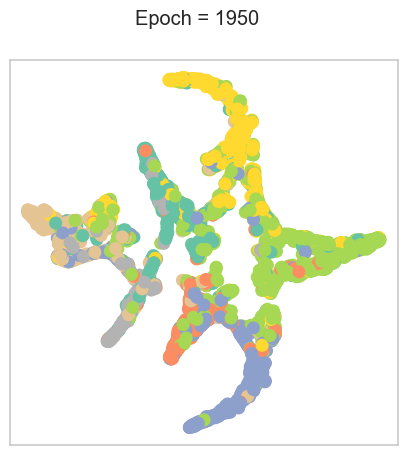

In [41]:
# Ignore deprecation warnings here
import warnings
warnings.filterwarnings('ignore')

# Train the model and save visualizations
images = []
for epoch in range(0, 2000):
    loss = train()
    if epoch % 50 == 0:
      out = model(data.x, data.edge_index)
      images.append(visualize(out, color=data.y, epoch=epoch))
print("TSNE Visualization finished.")

# Building a GIF from this

In [3]:
from moviepy.editor import ImageSequenceClip
fps = 1
filename = "E:\Python Projects\gif\embeddings.gif"
clip = ImageSequenceClip(images, fps=fps)
clip.write_gif(filename, fps=fps)

NameError: name 'images' is not defined

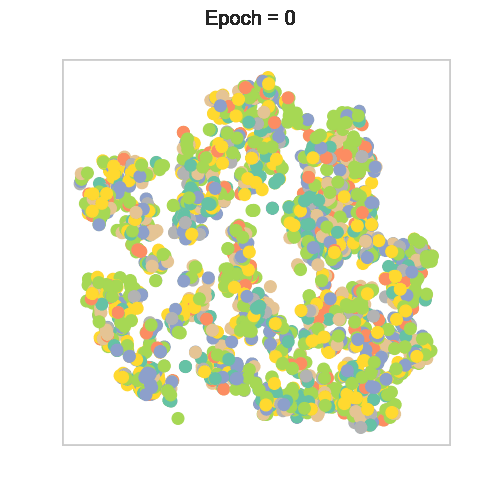

In [4]:
from IPython.display import Image
with open("E:\Python Projects\gif\embeddings.gif",'rb') as f:
    display(Image(data=f.read(), format='png'))